In [2]:
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge
import json

from pyinstrument import Profiler
%load_ext pyinstrument

from sklearn import set_config
set_config(assume_finite=True) 

import matplotlib.pyplot as plt

The pyinstrument extension is already loaded. To reload it, use:
  %reload_ext pyinstrument


# Procedure for generating VoC curves

1. Generate 120000 RFFs using `make_RFF`
2. For $t \in \{12, \dots, len(S)\}$:
   1. Standardize the RFFs by their standard deviation in the training sample i.e. sample $\{S_{t-T}, \dots S_{t-1}\}$ of the last $T$ observations, for $T \in \{12, 60, 120\}$. Also, standardize $S_{t}$ by the same standard deviation. Output `NaN` if $t < T$.
   2. Estimate the model by ridge regression with $P\in \{2,\dots, 12000\}$ and ridge shrinkage parameter $log_{10}(z) \in \{−3,\dots, 3\}$. In our case we are taking 9 values for $P$ and 7 values for $z$, so we have 63 models to estimate for each $t$.
3. From the sequence of out-of-sample predictions and strategy returns in step 2. calculate:
   1. average $||\hat{\beta}||^2$ across training samples,
   2. out-of-sample $R^2$ 
   3. out-of-sample average return of the timing strategy
   4. volatility of the timing strategy
   5. Sharpe ratio of the timing strategy


In the following subsections of the notebook we inspect each of the steps, check the results of each step and profile the code in each step to identify bottlenecks.

# 3. Calculate metrics

## 3.1. Unpack results into a multi-index dataframe

In [3]:
def make_rff(G, P, gamma=2, seed=59148, output_type='numpy'):
    np.random.seed(seed)
    omegas = np.random.normal(0, 1, (15, int(P/2)))
    A = gamma * G @ omegas
    S_sin = np.sin(A) 
    S_cos = np.cos(A)
    S = np.full((S_sin.shape[0], S_sin.shape[1] + S_cos.shape[1]), fill_value=np.nan, dtype=S_sin.dtype)
    S[:, 0::2] = S_sin
    S[:, 1::2] = S_cos

    if output_type == 'pandas':
        S = pd.DataFrame(data=S, index=G.index, columns=np.arange(P))
    elif output_type == 'numpy':
        return S
    else:
        raise ValueError('output_type must be "pandas" or "numpy"')

In [4]:
data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
P=12000 # number of pairs
gamma=2
seed=2

# inputs
G = data.iloc[:,:-1].values # remove last column which is the target variable
R = data.iloc[:,-1].values # target variable, it is already shifted in `processed_data.csv`
#S = make_rff(G, P, gamma=gamma, seed=seed, output_type='numpy')

In [5]:
def unpack_results(results, run_params, date_index):
    beta_norm_sq, return_forecasts, strategy_returns = results
    T_list, P_dict, z_list = run_params

    Plen = len(P_dict[str(T_list[0])])


    if type(z_list) == dict:
        raise ValueError('z_list must be a list, not a dictionary. Use `run_params_unpacking`, not `run_params`')

    # make dummy dataframes to be populated
    list_beta_norm_sq = {}
    list_return_forecasts = {}
    list_strategy_returns = {}

    # for T in T_list make dataframes
    for T_index, T in enumerate(T_list):

        list_beta_norm_sq.update({T: pd.DataFrame(data=beta_norm_sq[:,T_index, :, :].reshape(-1, Plen*len(z_list)), 
                                        index=date_index, 
                                        columns=pd.MultiIndex.from_product([P_dict[str(T)], z_list], 
                                                                        names=['P', 'z']))}) 
        list_return_forecasts.update({T: pd.DataFrame(data=return_forecasts[:,T_index, :, :].reshape(-1, Plen*len(z_list)), 
                                            index=date_index, 
                                            columns=pd.MultiIndex.from_product([P_dict[str(T)], z_list], 
                                                                            names=['P', 'z']))})
        list_strategy_returns.update({T: pd.DataFrame(data=strategy_returns[:,T_index, :, :].reshape(-1, Plen*len(z_list)), 
                                            index=date_index, 
                                            columns=pd.MultiIndex.from_product([P_dict[str(T)], z_list], 
                                                                            names=['P', 'z']))})

    beta_norm_sq_df = pd.concat(list_beta_norm_sq, axis=1)
    return_forecasts_df = pd.concat(list_return_forecasts, axis=1)
    strategy_returns_df = pd.concat(list_strategy_returns, axis=1)
    
    beta_norm_sq_df.columns.names = ['T', 'P', 'z']
    return_forecasts_df.columns.names = ['T', 'P', 'z']
    strategy_returns_df.columns.names = ['T', 'P', 'z']
    
    return beta_norm_sq_df, return_forecasts_df, strategy_returns_df

In [6]:
with open("../data/interim/final_simulation_outputs/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_dict = config['P_dict']
    P_max = 2000
    delta_t = config['delta_t']
    model_dict = {T: [Ridge(alpha=T*z, fit_intercept=False) for z in z_list] for T in T_list}

In [7]:
P_dict

{'12': [1, 2, 5, 9, 11, 12, 13, 15, 20, 45, 90, 250, 500, 2000],
 '60': [1, 7, 20, 40, 55, 59, 60, 61, 65, 80, 150, 500, 1000, 2000],
 '120': [1, 7, 30, 60, 90, 110, 118, 120, 122, 130, 150, 300, 1000, 2000]}

In [8]:
def plot_broken_x(df, T, z_list, y_label, save_path, ytype=None):
    f, (ax, ax2) = plt.subplots(1, 2, width_ratios=[3, 1], sharey=True)
    f.subplots_adjust(hspace=0.05)  # adjust space between axes

    df = df.loc[df['T']==T]
    x = df['c'].values
    y = df.loc[:, z_list].values

    # plot the same data on both axes
    ax.plot(x, y)
    ax2.plot(x, y)

    if T==12:
        ax.set_xlim(0, 50)
        ax2.set_xlim(990, 1000)
    elif T==60:
        ax.set_xlim(0, 10)
        ax2.set_xlim(195, 200)
    elif T==120:
        ax.set_xlim(0, 10)
        ax2.set_xlim(95, 100)
    else:
        raise ValueError('T must be 12, 60 or 120')

    # in case ytype is specified, set y limits like in VoC, for comparison
    # with the original plots 
    if ytype == "r2":
        ax.set_ylim(-3, 0)
        ax2.set_ylim(-3, 0)
    elif ytype == "beta":
        ax.set_ylim(0, 3)
        ax2.set_ylim(0, 3)
    elif ytype == "er":
        ax.set_ylim(0, 0.04)
        ax2.set_ylim(0, 0.04)
    elif ytype == "vola":
        ax.set_ylim(0, 5)
        ax2.set_ylim(0, 5)
    else:
        pass

    ax.set_ylabel(y_label)
    ax2.legend(z_list, title='z')
    f.suptitle(f'T={T}')

    # hide the spines between ax and ax2
    ax.spines['right'].set_visible(False)
    ax2.spines['left'].set_visible(False)
    ax.yaxis.tick_left()
    ax2.yaxis.tick_right()

    plt.ticklabel_format(axis='y', style='sci', scilimits=(-2,2))

    # set x label but place it at the center of the figure
    f.text(0.5, 0.04, 'c', ha='center', va='center')

    d = 0.02 # .015  # how big to make the diagonal lines in axes coordinates
    # arguments to pass plot, just so we don't keep repeating them
    kwargs = dict(transform=ax.transAxes, color='k', clip_on=False)
    ax.plot((1-d, 1+d), (-d, +d), **kwargs)
    ax.plot((1-d, 1+d), (1-d, 1+d), **kwargs)

    kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
    ax2.plot((-3*d, +3*d), (1-d, 1+d), **kwargs) # 3 corrects for ratio of subplot widths
    ax2.plot((-3*d, +3*d), (-d, +d), **kwargs)
    plt.savefig(save_path, dpi=300)
    plt.show()
    return None

In [9]:
run_params_unpacking = (T_list, P_dict, z_list) # !!!! IMPORTANT: using run_params instead of z_list causes a bug!!!
run_params_unpacking

([12, 60, 120],
 {'12': [1, 2, 5, 9, 11, 12, 13, 15, 20, 45, 90, 250, 500, 2000],
  '60': [1, 7, 20, 40, 55, 59, 60, 61, 65, 80, 150, 500, 1000, 2000],
  '120': [1, 7, 30, 60, 90, 110, 118, 120, 122, 130, 150, 300, 1000, 2000]},
 [0.0001, 0.001, 0.01, 0.1, 1, 10])

This mesh of P is ok. It is not as granular as the one in the VoC but captures the shape of VoC curves well. 

In [10]:
dates=data.index[min(T_list):]

In [11]:
# load numpy arrays from files
b = np.load(f"../data/interim/final_simulation_outputs/beta_norm_sq/{seed:04}beta_norm_sq.npy")
r = np.load(f"../data/interim/final_simulation_outputs/return_forecasts/{seed:04}return_forecasts.npy")
sr = np.load(f"../data/interim/final_simulation_outputs/strategy_returns/{seed:04}strategy_returns.npy")

In [12]:
beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)

## 3.2 Average $||\hat{\beta}||^2$ across training samples

In [13]:
mean_beta_norm_sq = beta_norm_sq_df.mean().unstack()
beta_norm = np.sqrt(mean_beta_norm_sq) # in VoC paper they plotted square root of norm of beta
beta_norm = beta_norm.reset_index()
beta_norm['c'] = beta_norm['P']/beta_norm['T']
beta_norm.head(20)

z,T,P,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,1,10.377243,4.169027,0.605312,0.063448,0.006376,0.000638,0.083333
1,12,2,15.089079,5.886077,0.858732,0.090188,0.009065,0.000907,0.166667
2,12,5,25.660751,9.024614,1.376146,0.146496,0.014747,0.001476,0.416667
3,12,9,34.189089,11.379383,1.812827,0.195583,0.019720,0.001974,0.750000
4,12,11,36.227306,12.137812,1.985060,0.215893,0.021790,0.002181,0.916667
5,12,12,37.028660,12.463109,2.062786,0.225116,0.022730,0.002275,1.000000
6,12,13,37.322175,12.787134,2.147651,0.235315,0.023772,0.002380,1.083333
7,12,15,37.239501,13.368797,2.320749,0.256638,0.025957,0.002599,1.250000
8,12,20,35.500791,14.116199,2.628339,0.296342,0.030050,0.003009,1.666667
9,12,45,24.625876,14.699922,3.599230,0.440579,0.045185,0.004530,3.750000


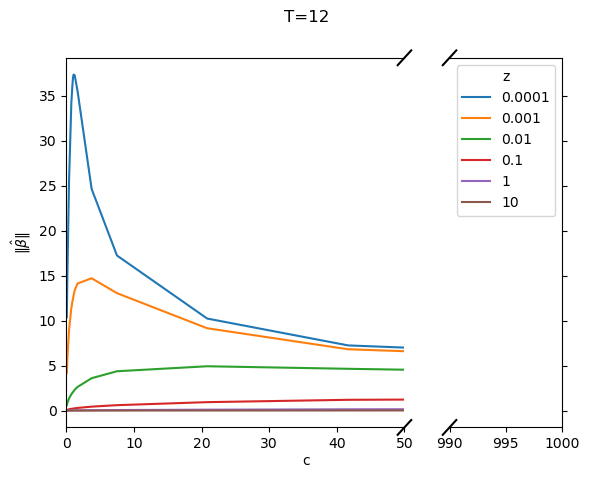

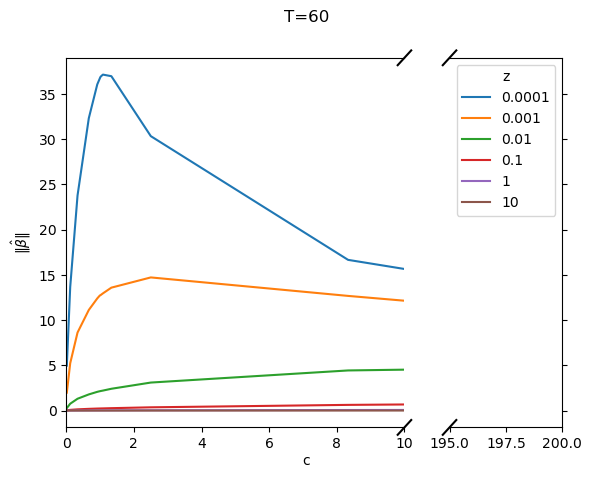

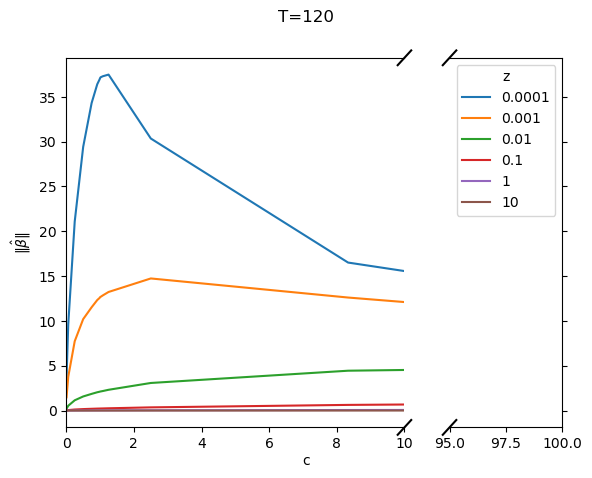

In [14]:
for T in T_list:
    plot_broken_x(beta_norm, T, z_list, 
                  y_label=r'$\| \hat {\beta}\|$', 
                  save_path=f"../reports/figures/beta_norm_T{T}_seed{seed}.png",
                  ytype=None)

## 3.3 Out-of-sample $R^2$ 



[VoC] Our empirical R2 calculation is one minus the ratio of out-of-sample forecast error variance to out-of-sample realized return variance. 

$$ R^2 = 1 - \frac{Var[R-\hat{R}]}{Var[R]}$$

In [15]:
realized_R = data.R.iloc[12:]
forecast_errors = return_forecasts_df.subtract(realized_R, axis=0)
R_sq = 1 - forecast_errors.var() / realized_R.var()
R_sq_temp = (R_sq
             .to_frame()
             .unstack()
             .droplevel(0, axis=1)
             .reset_index()
             )
R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
R_sq_temp.head()


z,T,P,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,1,-0.055423,-0.009534,-0.000766,-0.000545,-0.000538,-0.000538,0.083333
1,12,2,-0.137935,-0.025229,-0.001762,-0.000628,-0.000547,-0.000539,0.166667
2,12,5,-0.352932,-0.043036,-0.001049,-0.000486,-0.000532,-0.000537,0.416667
3,12,9,-0.587929,-0.066706,-0.002289,-0.000557,-0.000538,-0.000538,0.750000
4,12,11,-0.640756,-0.072451,-0.001943,-0.000476,-0.000529,-0.000537,0.916667


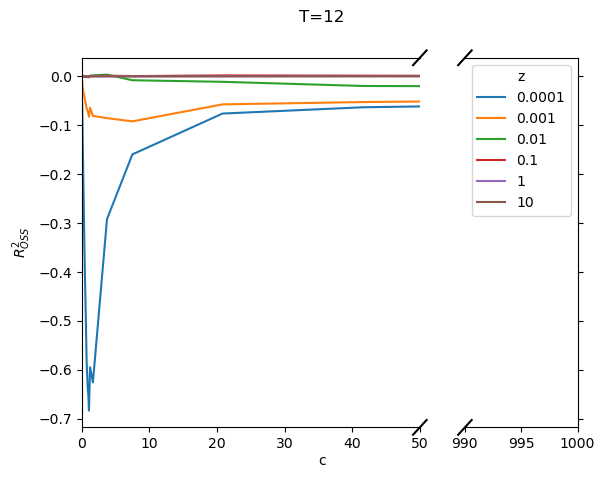

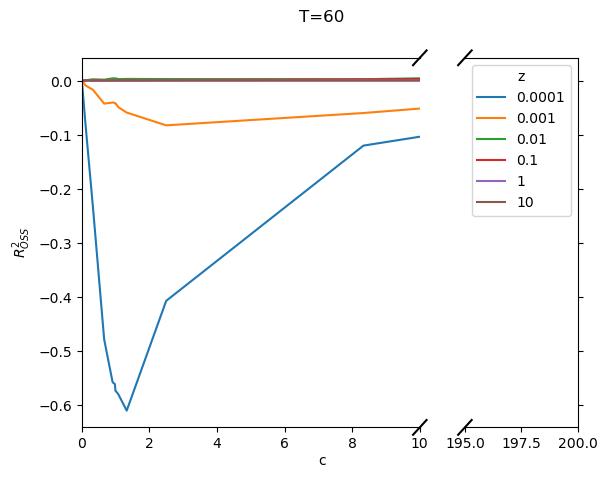

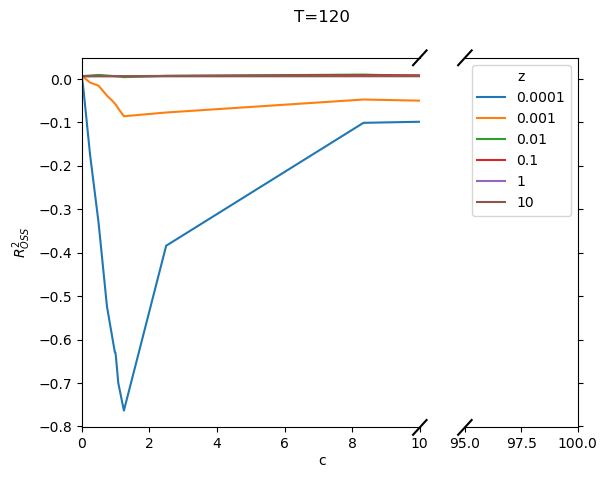

In [16]:
for T in T_list:
    plot_broken_x(R_sq_temp, T, z_list,
                  r'$R_{OSS}^2$',
                  f"../reports/figures/R2_T{T}_seed{seed}.png")

## 3.4 Out-of-sample average return of the timing strategy


In [17]:
strategy_returns = strategy_returns_df.mean().unstack().reset_index()
strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
strategy_returns.head()

z,T,P,0.0001,0.001,0.01,0.1,1.0,10.0,c
0,12,1,-0.000459,-0.000452,-0.000081,-0.000009,-8.780107e-07,-8.786653e-08,0.083333
1,12,2,-0.008980,-0.003211,-0.000417,-0.000043,-4.291533e-06,-4.292622e-07,0.166667
2,12,5,0.006471,0.003186,0.000613,0.000068,6.824766e-06,6.831816e-07,0.416667
3,12,9,0.024085,0.004489,0.000590,0.000064,6.463502e-06,6.470101e-07,0.750000
4,12,11,0.024721,0.004892,0.000771,0.000089,9.046647e-06,9.062794e-07,0.916667


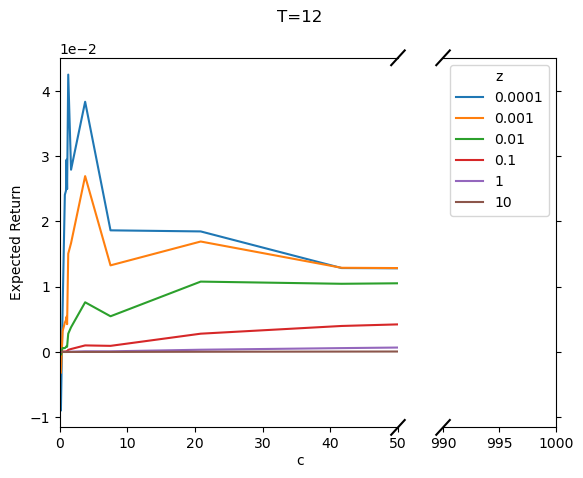

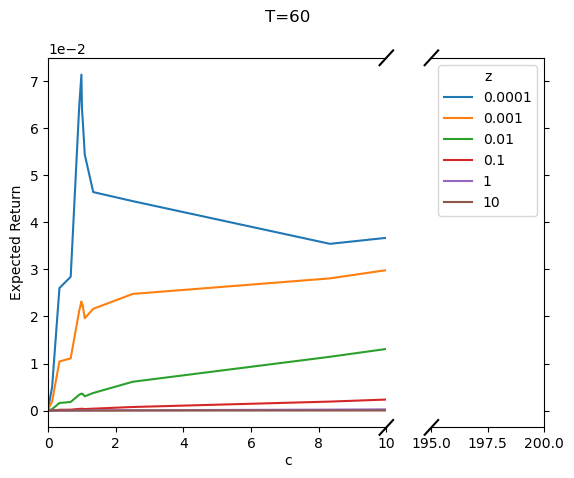

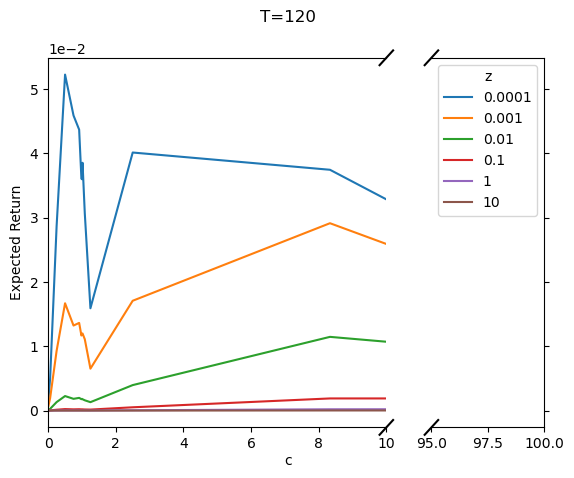

In [18]:
for T in T_list:
    plot_broken_x(strategy_returns, T, z_list,
                  "Expected Return",
                  f"../reports/figures/ER_T{T}_seed{seed}.png",
                  ytype=None)

## 3.5 Volatility of the timing strategy

In [19]:
strategy_vola = strategy_returns_df.std().unstack().reset_index()
strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

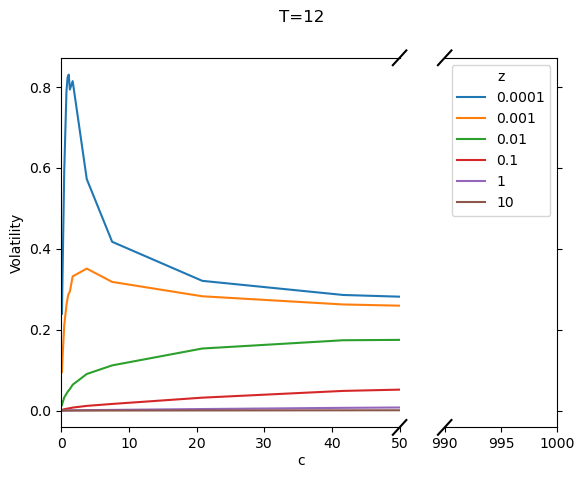

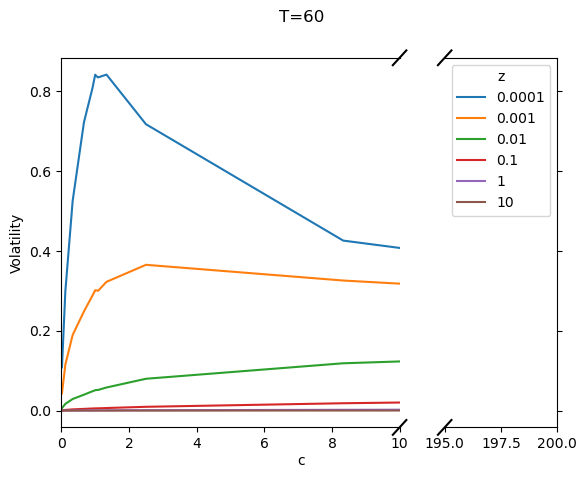

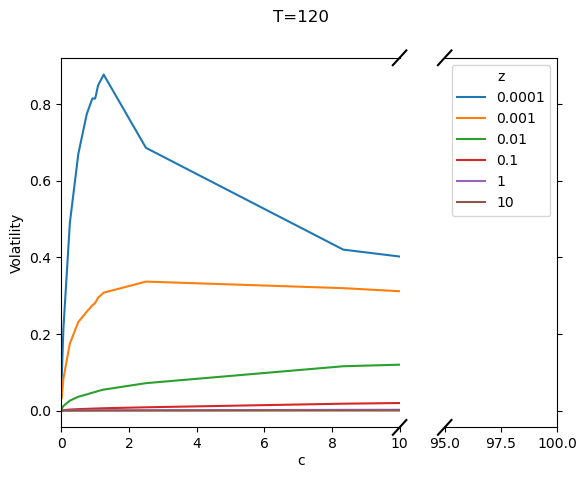

In [20]:
for T in T_list:
    plot_broken_x(strategy_vola, T, z_list,
                  "Volatility",
                  f"../reports/figures/vola_T{T}_seed{seed}.png",
                  ytype=None)

## 3.6 Sharpe ratio of the timing strategy

Our empirical Sharpe ratio calculation uses the centered standard deviation in the denominator.

# 4. Generate VoC curves by averaging over many runs

In [26]:
# for seed in range(151, 218) load results, calculate metrics and average dataframes over different seeds

with open("../data/interim/final2_simulation_outputs/config.json", 'r') as fp:
    config = json.load(fp)
    last_run_seed = config['last_run_seed']
    gamma = config['gamma']
    T_list = config['T_list']
    z_list = config['z_list']
    P_dict = config['P_dict']
    P_max = 12000
    delta_t = config['delta_t']

data = pd.read_csv("../data/processed/processed_data.csv", index_col=0, parse_dates=True)
dates=data.index[min(T_list):]

run_params_unpacking = (T_list, P_dict, z_list) # !!!! IMPORTANT: using run_params instead of z_list causes a bug!!!
run_params_unpacking

first_pass = True

for seed in range(from_seed, to_seed+1):

    # load results
    b = np.load(f"../data/interim/final2_simulation_outputs/beta_norm_sq/{seed:04}beta_norm_sq.npy")
    r = np.load(f"../data/interim/final2_simulation_outputs/return_forecasts/{seed:04}return_forecasts.npy")
    sr = np.load(f"../data/interim/final2_simulation_outputs/strategy_returns/{seed:04}strategy_returns.npy")

    # unpack results
    beta_norm_sq_df, return_forecasts_df, strategy_returns_df = unpack_results((b, r, sr), run_params_unpacking, dates)

    # calculate metrics
    # beta
    mean_beta_norm_sq = beta_norm_sq_df.mean().unstack()
    beta_norm = np.sqrt(mean_beta_norm_sq) # in VoC paper they plotted square root of norm of beta
    beta_norm = beta_norm.reset_index()
    beta_norm['c'] = beta_norm['P']/beta_norm['T']

    # R2
    realized_R = data.R.iloc[12:]
    forecast_errors = return_forecasts_df.subtract(realized_R, axis=0)
    R_sq = 1 - forecast_errors.var() / realized_R.var()
    R_sq_temp = (R_sq
                .to_frame()
                .unstack()
                .droplevel(0, axis=1)
                .reset_index()
                )
    R_sq_temp['c'] = R_sq_temp['P']/R_sq_temp['T']
    R_sq_temp.head()

    # expected returns
    strategy_returns = strategy_returns_df.mean().unstack().reset_index()
    strategy_returns['c'] = strategy_returns['P']/strategy_returns['T']
    strategy_returns.head()

    # volatility
    strategy_vola = strategy_returns_df.std().unstack().reset_index()
    strategy_vola['c'] = strategy_vola['P']/strategy_vola['T']

    if first_pass:
        beta_norm_avg = beta_norm
        R_sq_avg = R_sq_temp
        strategy_returns_avg = strategy_returns
        strategy_vola_avg = strategy_vola
    else:
        # average dataframes over different seeds
        # fill_value=0 makes addition use 0 for missing values. I did not see any NaNs in the dataframes
        beta_norm_avg = beta_norm_avg.add(beta_norm, fill_value=0) 
        R_sq_avg = R_sq_avg.add(R_sq_temp, fill_value=0)
        strategy_returns_avg = strategy_returns_avg.add(strategy_returns, fill_value=0)
        strategy_vola_avg = strategy_vola_avg.add(strategy_vola, fill_value=0)

beta_norm_avg.loc[:,z_list] = beta_norm_avg.loc[:,z_list] / (to_seed - from_seed)
R_sq_avg.loc[:,z_list] = R_sq_avg.loc[:,z_list] / (to_seed - from_seed)
strategy_returns_avg.loc[:,z_list] = strategy_returns_avg.loc[:,z_list] / (to_seed - from_seed)
strategy_vola_avg.loc[:,z_list] = strategy_vola_avg.loc[:,z_list] / (to_seed - from_seed)


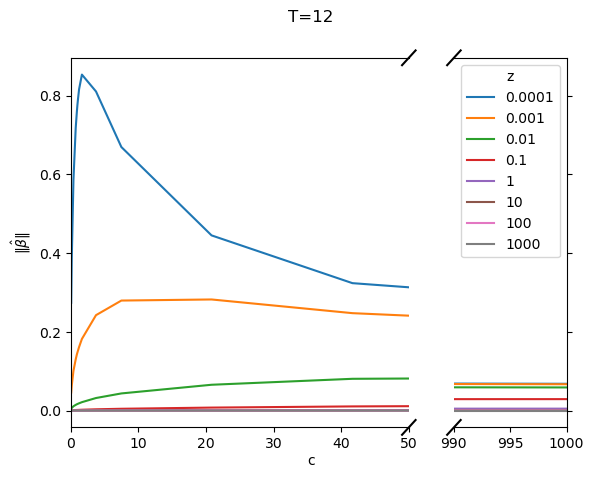

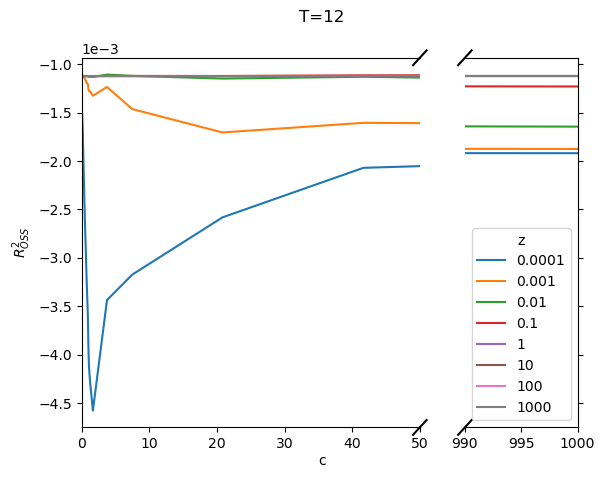

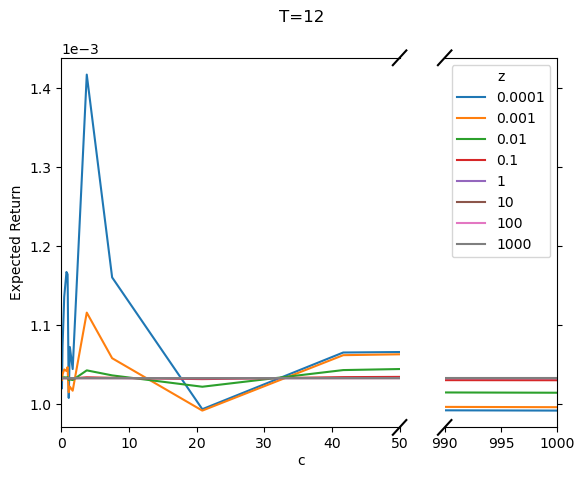

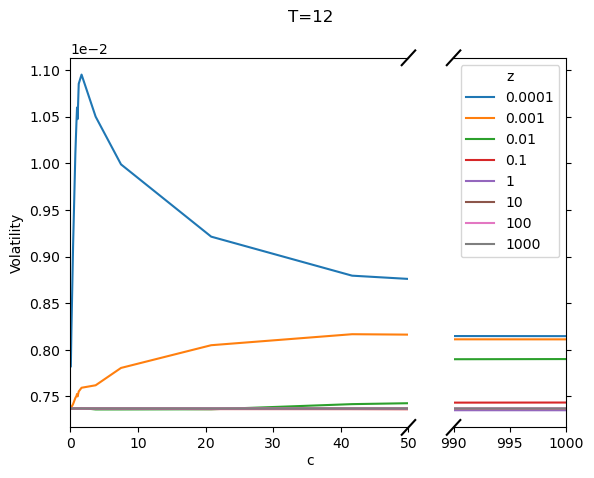

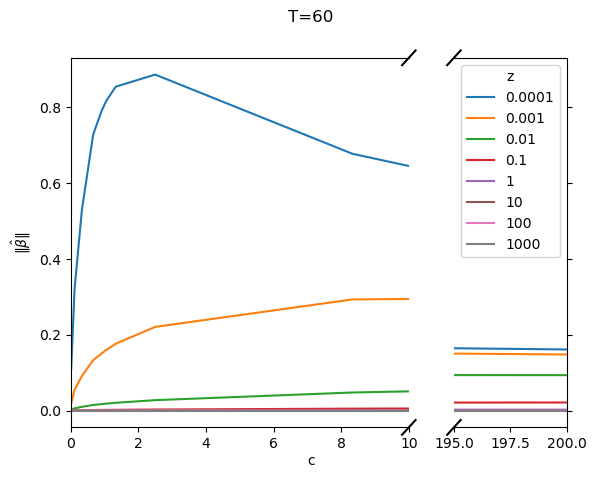

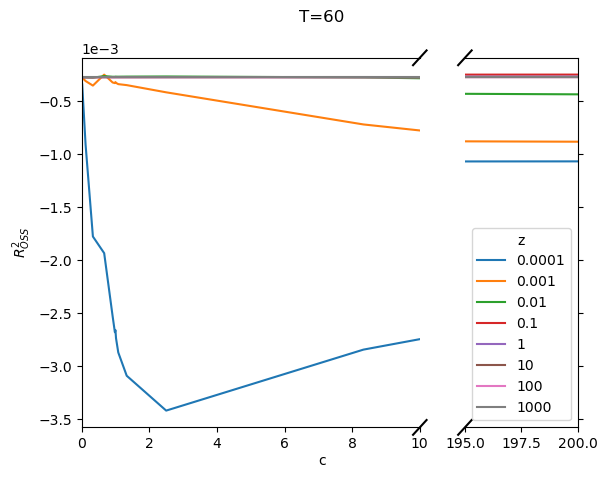

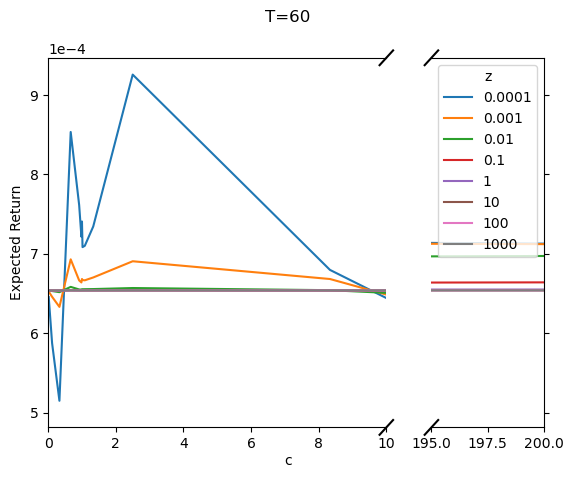

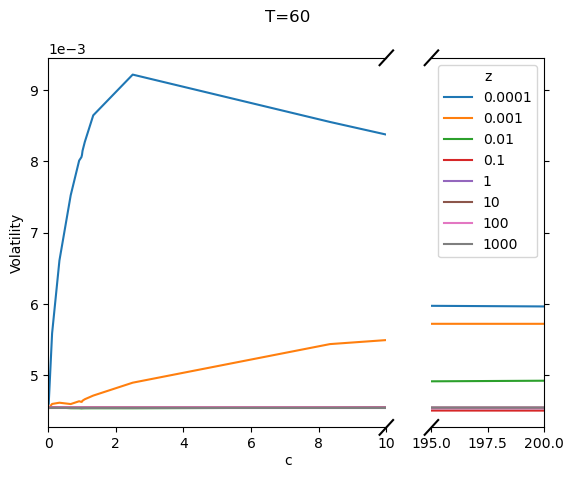

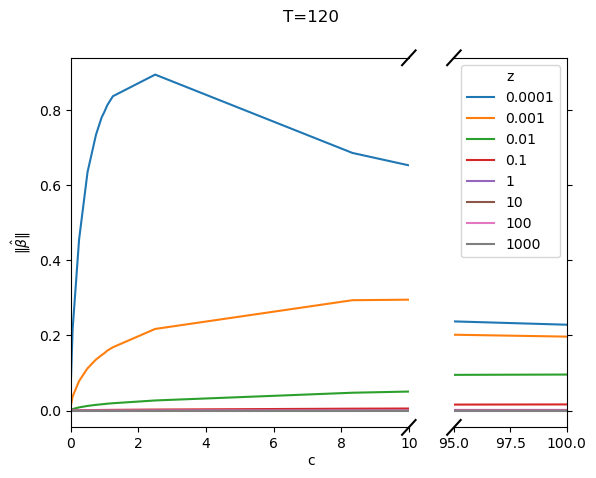

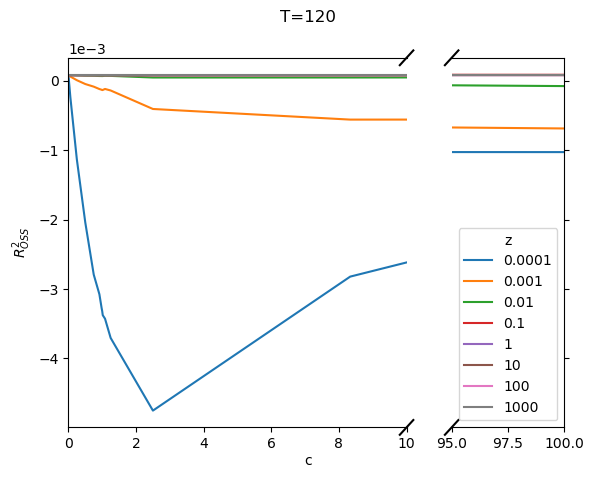

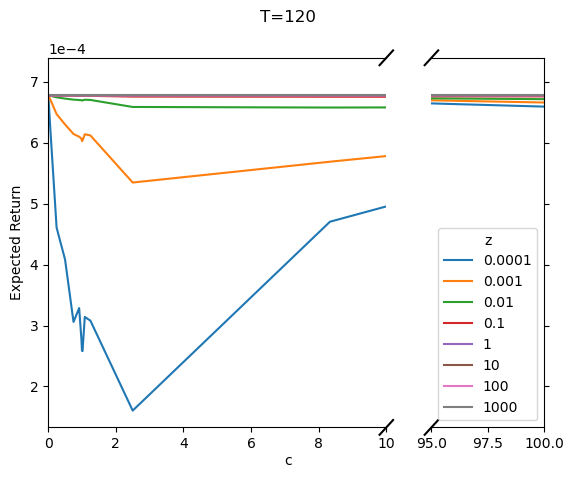

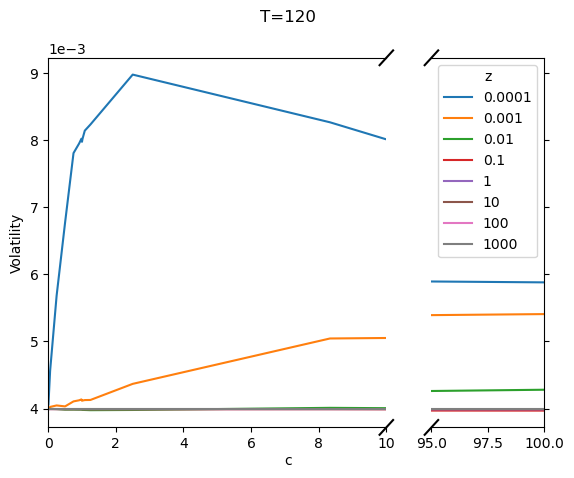

In [27]:
# plot averaged dataframes
for T in T_list:
    plot_broken_x(beta_norm_avg, T, z_list, 
                  y_label=r'$\| \hat {\beta}\|$', 
                  save_path=f"../reports/figures/beta_norm_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(R_sq_avg, T, z_list,
                    r'$R_{OSS}^2$',
                    f"../reports/figures/R2_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(strategy_returns_avg, T, z_list,
                    "Expected Return",
                    f"../reports/figures/ER_T{T}_seed{from_seed}_{to_seed}.png")
    plot_broken_x(strategy_vola_avg, T, z_list,
                    "Volatility",
                    f"../reports/figures/vola_T{T}_seed{from_seed}_{to_seed}.png")
    
    